## Describe the polygon extensions to the NIC climatology 

This document demonstrates how we extend the possible ice regions for the nsidc-0622 valid-ice-masks.

From our documentation: 
http://nsidc.org/data/docs/daac/nsidc0622-valid-ice-masks/#spatialcover

The spatial coverage of the input NIC climatologies is limited to north of
45° N latitude, however, there are instances where valid sea ice occurs south
of this latitude for certain winter months. To capture commonly occurring ice
in these areas, the valid-ice region in the mask is extended in two separate
regions for the months of December and January through April based on the
experience of the investigators with many other sources of sea ice
information. See Figure 1.

One extension is in the Sea of Japan and the Sea of Okhotsk. This region is
between 126° E and 146° E and extends from 45° N latitude to the line formed
between the two points (42° N, 126° E) and (39.5° N, 146° E).

The other extension covers much of the Bohai Sea. This region is between
126° E to 115° E and 45° N to 38° N.


In [13]:
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt


Read in the one of the NSIDC ice masks as your baseline.

When the data is live, we can put a command that would actually download this mask file here but for now It's predownloaded.


In [14]:
mask_fn = '../data/nsidc0622/NIC_valid_ice_mask.N25km.01.1972-2007.nc'
nc = Dataset(mask_fn, 'r')
mask = nc.variables['loci_flag'][:]
lats = nc.variables['latitude'][:]
lons = nc.variables['longitude'][:]

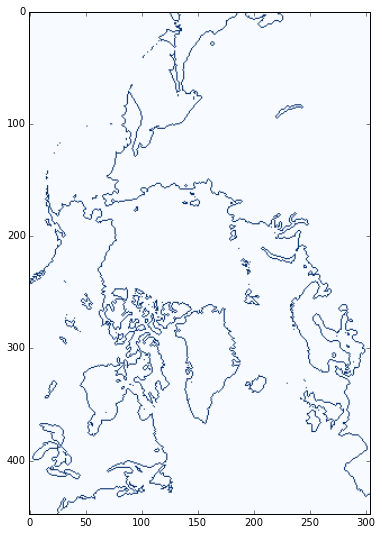

In [15]:
# create coastlines for display
coast = mask == 2
with mpl.rc_context(rc={'figure.figsize': (10,9), 'axes.grid':False}, ):
    plt.imshow(coast, cmap="Blues")

### Create Bohai region

bohai region = 126° E to 115° E and 45° N to 38° N.

Set a variable with only bohai region set.

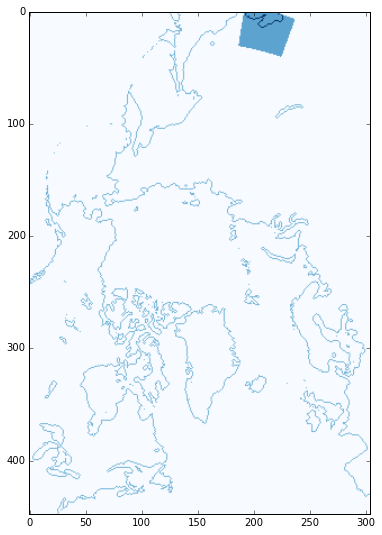

In [16]:
bohai = ((lons >= 115) & (lons <= 126) & (lats <= 45) & (lats >= 38))
with mpl.rc_context(rc={'figure.figsize': (10,9), 'axes.grid':False}, ):
    plt.imshow((bohai*1.2) + coast, cmap="Blues")

### Create Okhotsk region

One extension is in the Sea of Japan and the Sea of Okhotsk. This region is
between 126° E and 146° E and extends from 45° N latitude to the line formed
between the two points (42° N, 146° E) and (39.5° N, 126° E).


Set a variable with only points inside the okhotsk region nonzero

Create a Path object with the lonx,lat aka (x,y) pairs for the polygon we wish to fill with possible ice.
Create a subset of your entire grid called candidates that encompases the entire polygon


In [17]:
okhotsk = mpl.path.Path([[126, 39.5], [126, 45], [146, 45], [146, 42], [126, 39.5]])
candidates = ((lons >= 126) & (lons <= 146) & (lats >= 38) & (lats <= 45))

lons[candidates].shape
lats[candidates].shape


(2305,)

Create the okhotsk_mask by filling a blank variable with 1s where we are inside your desired polygon

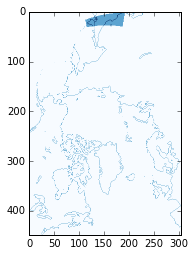

In [18]:
okhotsk_mask = mask.copy() * 0
inside = [okhotsk.contains_point(x) for x in  zip(lons[candidates], lats[candidates])]
okhotsk_mask[candidates] = np.where(inside, 1, 0)
plt.imshow((okhotsk_mask*1.2) + coast, cmap="Blues")

So here's the regions we want to show the user that we adjusted by hand

<matplotlib.contour.QuadContourSet instance at 0x10c2df3b0>

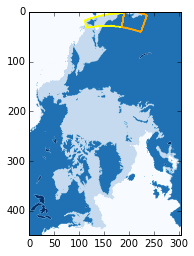

In [19]:

plt.imshow(mask, cmap='Blues')
plt.contour(bohai, colors=('orange'))
plt.contour(okhotsk_mask, colors=('yellow'))
plt.contour(bohai, colors=('orange'))


But we'd like it to look nice like in the documentation

In [20]:
# set up a color dictionary
c = {'land': "#BE9F82",
     'ice': "#FFFFFF",
     'lake': "#0B3168",
     'coast': "#000000",
     'ocean': "#82B2D1",
     'okhotsk': "#A9B731",
     'bohai': "#E8924B"}

In [21]:
# set up our colortable and normalize function

# remember:
# flag_values: [0 1 2 3 4]
# flag_meanings: ocean possible_ice coast land lake
colormap = mpl.colors.ListedColormap([c['ocean'], c['ice'], c['coast'], c['land'],c['lake'], c['bohai'], c['okhotsk']])
bounds = [0, 1, 2, 3, 4, 5, 6, 7]
norm = mpl.colors.BoundaryNorm(bounds, colormap.N)


Create new images
Start with a copy of the January mask
Where we're in the bohai region and there is open water in the January masks, set the value to 5
Where we're in the okhotsk region and there is open water in the January masks, set the value to 6

In [22]:
mmask = mask.copy()
mmask= np.where(bohai & (mmask==1), 5, mmask)
mmask = np.where(okhotsk_mask & (mmask == 1), 6, mmask)



Create a nice looking image with the possible ice colored and the lat/lon regions bounded

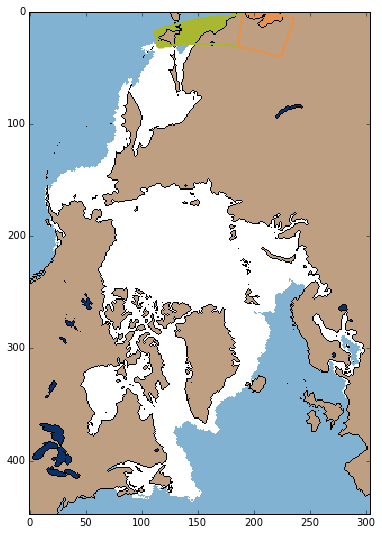

In [23]:
with mpl.rc_context(rc={'figure.figsize': (10,9), 'axes.grid':False}, ):
    plt.imshow(mmask, interpolation="nearest", cmap=colormap, norm=norm)
    plt.contour(okhotsk_mask, colors=(c['okhotsk']))
    plt.contour(bohai, colors=(c['bohai']))
    # save an output image
    plt.gcf().savefig('../output/sea_ice_example.png', bbox_inches='tight')